## LAB360: Build an Agentic App with PostgreSQL, GraphRAG, and Semantic Kernel

### Part 3.1: Introduction

**Welcome to the LAB360 Agent App Notebook!**

In this notebook, you will build a Semantic Kernel Agent that can reason over our database of legal cases you deployed in the previous steps. You will also incorporate external web service data, and use memory to improve its responses over time.

Semantic Kernel is an open-source SDK developed by Microsoft that helps developers create advanced AI agents by combining:

- LLMs (Large Language Models) like OpenAI's GPT models
- Plugins (custom tools and functions the agent can call)
- Memory (saving and recalling past conversations or facts)

An Agent in Semantic Kernel is a smart assistant that can:

- Respond to user prompts
- Decide which plugin functions to call
- Use external knowledge sources like databases or APIs
- Build better, grounded answers by combining model reasoning with real-world data

You are about to connect powerful components:

- Azure OpenAI (for embeddings and LLM chat completions)
- PostgreSQL with Vector and Graph extensions (for fast semantic and graph search)
- APIs for real-world data (historical weather evidence)

As you progress, each section of code will incrementally build up these capabilities, and by the final step, you’ll have a highly capable legal research assistant.

**Architecture Diagram**

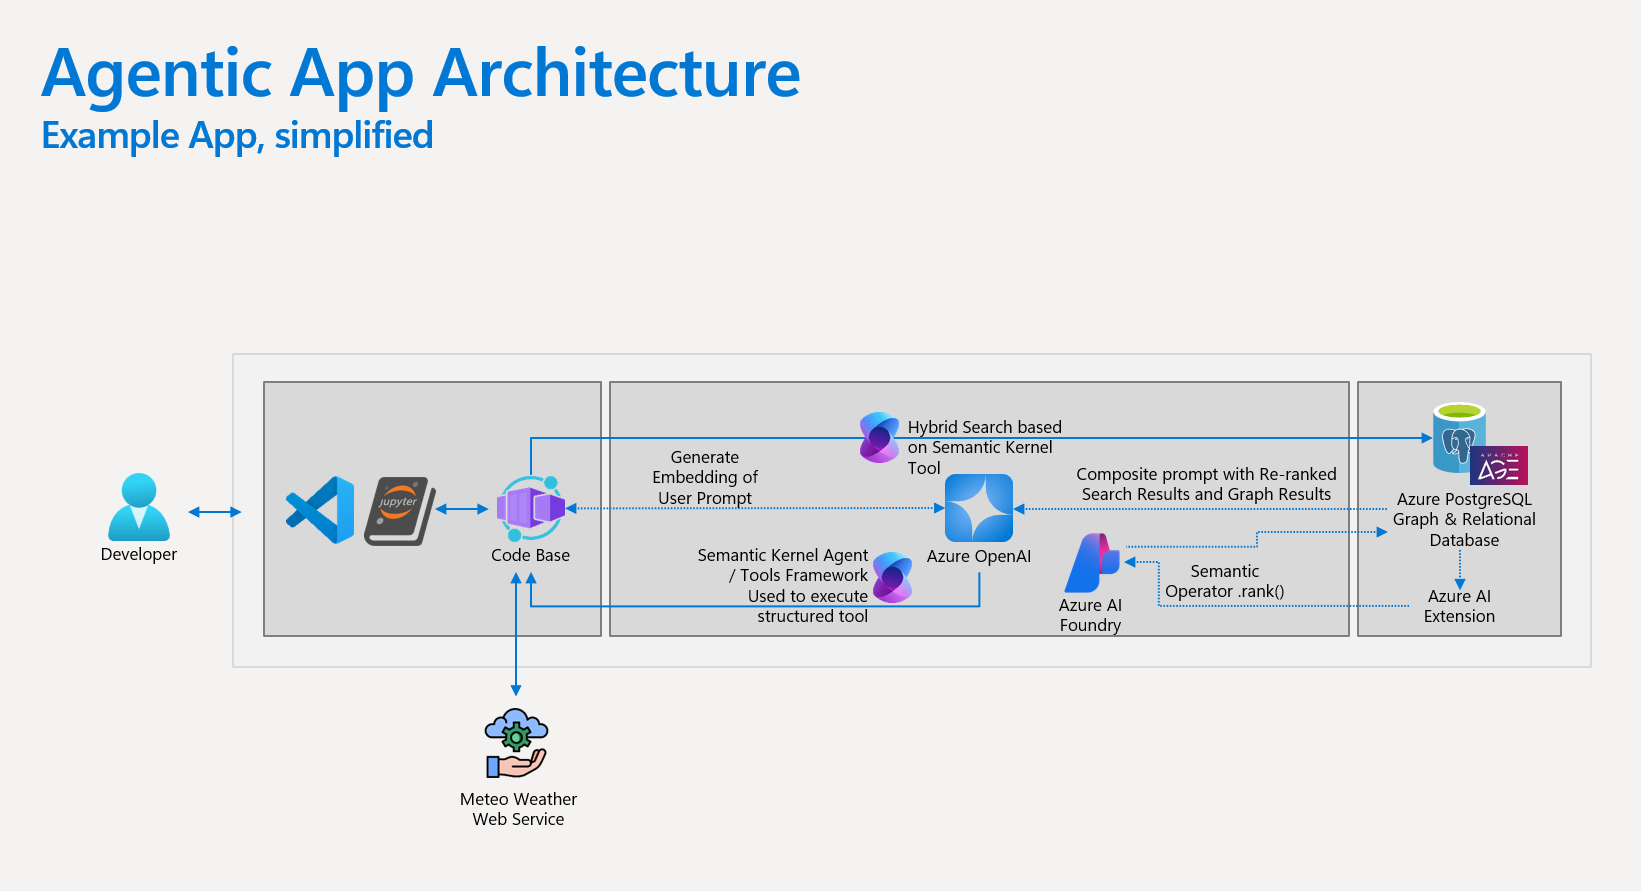

### Part 3.2: Setup the Agent App Python imports

> **Note:** In your lab environment, we already have the PIP packages pre-deployed that are needed by the import statements in the following code block, so you do not need to install these.  But just for reference and for future usage of this code, here are the packages used:
> - PostgreSQL connectivity (`psycopg`, `psycopg-binary`, `psycopg-pool`)
> - Modeling and validation (`pydantic`)
> - OpenAI and Semantic Kernel integration (`openai`, `semantic-kernel`)
> - Notebook compatibility (`nest_asyncio`, `ipykernel`)

Local setup:

```python
python -m pip install -r requirements.txt
```

##### 🧠 *Technical Notes*

This set of imports prepares the technical foundation for building an AI-powered agent that interacts with a PostgreSQL database and OpenAI services. `nest_asyncio` is used to allow nested event loops, which is important when running asynchronous code inside a Jupyter notebook. Core Python modules like `os`, `asyncio`, `uuid`, and `requests` handle environment access, asynchronous execution, unique ID generation, and external API calls, respectively. `psycopg2` provides database connectivity to PostgreSQL, while `pydantic` offers structured data validation and modeling.

The Semantic Kernel libraries enable creation of intelligent agents (`ChatCompletionAgent`), define plugins and function tools (`kernel_function`), manage prompt settings, and handle retrieval-augmented memory through `PostgresMemoryStore` and `SemanticTextMemory`. Finally, Azure OpenAI integration components (`AzureChatCompletion`, `AzureTextEmbedding`) allow the agent to generate responses and embeddings using cloud-based AI models.

##### ⚙️ *Code Review Tasks*

1. Run the cell below using the "▶" icon next to the cell.

1. This will run the code and show the output below.  Since these are just imports, there is nothing to show at the end other than a check mark showing success.

    > **Note:** The first time this code block is ran, it may take around 20-30 seconds.

In [ ]:
import nest_asyncio
nest_asyncio.apply()

import os, asyncio, uuid, requests
import psycopg
from typing import Annotated
from pydantic import Field
from dotenv import load_dotenv

# Agent Framework
from agent_framework.azure import AzureOpenAIChatClient
from agent_framework import ai_function, ChatMessage, TextContent, Role

# Azure credentials
from azure.identity import DefaultAzureCredential, AzureCliCredential

# Mem0 client for persistent memory
from mem0 import Memory

### Part 3.3: Environment Setup

Before running the notebook, we need to ensure our environment variables are properly set up. If you've followed the lab instructions and run `azd up` successfully, most of the required environment variables should already be written to a `.env` file in the project root by the `write_env.sh` script.

The `.env` file should contain:
- Azure OpenAI configuration (endpoint, key, deployment)
- Database configuration (host, name, user, password, etc.)

If you need to create a `.env` file manually, you can copy the `.env.sample` file in the project root and fill in your specific values.

Run the following code block to load the environment variables from the `.env` file:

In [ ]:
load_dotenv(override=True)

# Choose a credential strategy
azure_credential = DefaultAzureCredential()
azure_cli_credential = AzureCliCredential()

AZURE_OPENAI_ENDPOINT   = os.environ["AZURE_OPENAI_ENDPOINT"]
AZURE_OPENAI_DEPLOYMENT = os.environ["AZURE_OPENAI_DEPLOYMENT"]
AZURE_OPENAI_KEY        = os.environ["AZURE_OPENAI_KEY"]
AZURE_EMBED_DEPLOYMENT  = os.environ["AZURE_EMBED_DEPLOYMENT"]
AZURE_API_VERSION       = os.environ["AZURE_API_VERSION"]

DB_CONFIG = {
    "host":     os.environ["AZURE_PG_HOST"],
    "dbname":   os.environ["AZURE_PG_NAME"],
    "user":     os.environ["AZURE_PG_USER"],
    "password": os.environ["AZURE_PG_PASSWORD"],
    "port":     os.environ["AZURE_PG_PORT"],
    "sslmode":  os.environ.get("AZURE_PG_SSLMODE", "require"),
}

### Part 3.4: Create Semantic Kernel Plugin for Basic Database Queries

##### 🧠 *Technical Notes*

In this step, we create a custom plugin called DatabaseSearchPlugin to give our agent the ability to interact directly with the case law database using basic SQL queries. This plugin uses the psycopg2 library to establish a connection to PostgreSQL, execute queries, and return results. We define two simple but important functions: `count_cases()` to return the total number of cases in the database, and `search_cases(keyword)` to perform a keyword search against case opinions. Each function is decorated with `@kernel_function`, which registers it as a callable tool within the Semantic Kernel framework. This makes these database operations available to the agent automatically during conversation, enabling the agent to retrieve real-time, grounded information from our dataset.

##### ⚙️ *Code Review Tasks*

1. Review the code below, notice the print statements outputting to the terminal the name of the function when it is called.  This will be helpful later when we run the agent, and we want to see what functions it chose to call.

1. Run the cell below using the "▶" icon next to the cell.

1. This will run the code and show the output below.  Since these are just imports, there is nothing to show at the end other than a check mark showing success.

In [ ]:
@ai_function(description="Return the total number of cases in the database.")
def count_cases() -> str:
    print("count_cases was called")
    with psycopg.connect(**DB_CONFIG) as conn, conn.cursor() as cur:
        cur.execute("SELECT COUNT(*) FROM cases;")
        n = (cur.fetchone() or [0])[0]
        return str(n)

@ai_function(description="Find cases using an exact keyword match.")
def search_cases(keyword: Annotated[str, Field(description="Keyword to ILIKE-match in case opinions")],
) -> str:
    print("search_cases was called")
    with psycopg.connect(**DB_CONFIG) as conn, conn.cursor() as cur:
        cur.execute(
            """
            SELECT id, name, opinion
            FROM cases
            WHERE opinion ILIKE %s
            LIMIT 10;
            """,
            (f"%{keyword}%",),
        )
        rows = cur.fetchall()
    if not rows:
        return "No matches"
    return "\n".join(f"{r[0]}: {r[1]}: {r[2][:1000]}" for r in rows)

### Part 3.5: Test Run of our New Agent

##### 🧠 *Technical Notes*

Now that we have created our first plugin, we're ready to assemble and test an initial version of our agent. In this step, we create a default `OpenAIChatPromptExecutionSettings` to define basic settings. We then create an instance of `AzureChatCompletion`, which serves as the underlying communication layer between our agent and Azure OpenAI. Using these components, we instantiate a `ChatCompletionAgent`, providing it a name, a set of behavioral instructions, and a list of available plugins (in this case, just `DatabaseSearchPlugin`).

Finally, we send a sample user query to the agent and retrieve its response. This test validates that our agent can successfully invoke plugin functions, query the database, and integrate the results into a natural language reply.

##### ⚙️ *Code Review Tasks*

1. Review the code below, notice the following:
    - Inside `ChatCompletionAgent` we define `instructions` which act as notion of a "system prompt" for the Agent to define its purpose and goals
    - For now we are passing in our `DatabaseSearchPlugin` class, we will be creating more PlugIns to enhance the functionality of our agent in the next steps
    - Notice the `user_query` variable, and how it is asking how many cases there are, plus about water leaking cases.

1. Run the cell below using the "▶" icon next to the cell.  This invokes the agent and subsequent LLM calls, this may take a few moments to run.

1. After the code runs, notice the following:
    - There should have been 2 functions called: `count_cases` and `search_cases`
    - This happened because the agent interpreted the prompt and made a decision to call these 2 functions
    - Notice how we got back a clear response of 377 cases are in our database.  This was based on our `count_cases` database function giving the LLM grounded truth about our dataset.
    - Lastly, notice how we asked for 10 cases, but only got 2.  This is because our `search_cases` function is just the ILIKE operator and not yet using a vector search.  It could only find 2 cases that matching using the basic keyword ILIKE search.  In our next lab sections, we will see how we can improve on this.

In [ ]:
client = AzureOpenAIChatClient(
    endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
    deployment_name=os.environ["AZURE_OPENAI_DEPLOYMENT"],
    api_key=os.environ["AZURE_OPENAI_KEY"],    
)

agent = client.create_agent(
    instructions=(
        "You are a helpful legal assistant. Respond with the case names, why each is relevant, "
        "and a short one-sentence summary of the opinion."
    ),
    tools=[count_cases, search_cases],
)

user_query = "How many cases are there, and find me 10 cases regarding the notion of water leaking."

print("// Functions the Agent Called: //")
result = await agent.run(user_query)

print("// Agent Response: //")
print(result.text)

### Part 3.6: Improve Agent Accuracy by Adding Semantic Operators .rank() function

##### 🧠 *Technical Notes*

In this step, we add a new plugin called `SemanticRerankingPlugin` to increase the precision of our agent’s search results. Instead of relying only on keyword matching, this plugin uses semantic search and re-ranking to evaluate results based on the meaning and intent of the user query.

It works in two phases: first, it performs a vector similarity search using Azure OpenAI embeddings to find approximately relevant cases; then, it reorders these using a separate model (e.g., `semantic_relevance`) that scores and ranks the results for deeper semantic alignment. This two-step approach helps the agent prioritize results that are not just textually similar, but also topically and contextually relevant—making it ideal for legal queries where nuance matters. As with other tools, this function is registered using `@kernel_function`, so the agent can intelligently decide when to use it.

##### ⚙️ *Code Review Tasks*

1. Review the code:
    - Notice the following enhancements:
        - This plugin introduces a function called `search_semantic_reranked_cases`, designed to deliver higher-quality search results by understanding the semantic meaning of the query rather than relying on basic keyword matches.
        - The function is decorated with `@kernel_function`, which makes it available to the agent as a callable tool-this is how Semantic Kernel enables function calling automatically based on user intent.

    - Check out the SQL logic inside the code, notice how it includes two key phases:
        - (Phase 1) A vector similarity search using OpenAI-generated embeddings to find top 40 candidate cases.
        - (Phase 2) A semantic re-ranking step that uses an external re-ranker model (semantic_relevance) to evaluate and reorder those 40 based on relevance scores.
        - This hybrid approach helps ensure that even when the user’s phrasing doesn’t exactly match the database text, relevant results can still be surfaced based on meaning and context.

    - Observe how this plugin builds on the earlier keyword search:
        - The previous `search_cases()` method used `ILIKE` for fuzzy keyword matching. That works for exact or near-exact phrases but misses nuance.
        - This plugin improves accuracy and recall, especially for complex queries or abstract legal concepts where keyword overlap may be weak.
        - This function will be automatically called by the agent if the prompt includes phrases like "high accuracy is important" or contains complex, open-ended search intent.
        - For example, a prompt like: "*Help me find the most relevant cases about tenant water damage, with high accuracy*" will likely trigger this plugin over the basic one.

1. Finally, run the code block cell by clicking the "▶" button on the left side of the code block.
    - This will run the code but there will be no output yet.
    - Since this is just a class definition, there is nothing to show at the end other than a check mark showing success.

In [ ]:
@ai_function(
    description=(
        "Use semantic vector search and re-ranking to find cases that best match the query "
        "intent. Use when high accuracy is needed."
    )
)
def search_semantic_reranked_cases(
    query: Annotated[str, Field(description="Natural language query for legal cases")],
) -> str:
    print("search_semantic_reranked_cases was called")
    with psycopg.connect(**DB_CONFIG) as conn, conn.cursor() as cur:
        cur.execute(
            """
            WITH vector_candidates AS (
                SELECT
                    id AS case_id,
                    name AS case_name,
                    opinion,
                    ROW_NUMBER() OVER (
                    ORDER BY opinions_vector <=> azure_openai.create_embeddings('text-embedding-3-small', %s)::vector
                    ) AS rank_order
                FROM cases
                ORDER BY opinions_vector <=> azure_openai.create_embeddings('text-embedding-3-small', %s)::vector
                LIMIT 40
            ),
            ranked_results AS (
                SELECT
                    case_id, case_name, opinion, rank_order,
                    azure_ai.rank(%s, ARRAY[opinion], 'gpt-4o') AS ranking_result
                FROM vector_candidates
            )
            SELECT case_id, case_name, opinion, ranking_result
            FROM ranked_results
            ORDER BY rank_order
            LIMIT 10;
            """,
            (query, query, query),
        )
        rows = cur.fetchall()
    if not rows:
        return "No matches"
    return "\n".join(f"{r[0]}: {r[1]}: {r[2][:1000]}" for r in rows)

### Part 3.7: Add a GraphRAG Query PlugIn to the Agent for Additional Accuracy Improvements

##### 🧠 *Technical Notes*

In this step, we build another advanced plugin, `GraphDatabasePlugin`, that combines vector search with graph analysis to find the most influential cases related to a query topic. The `search_graph_cases` method first uses an embedding-based similarity search to semantically rank cases from the cases table. This ensures that only cases meaningfully related to the query are considered further.

After narrowing the results semantically, the query leverages **Apache AGE** - a PostgreSQL extension that enables property graph querying via Cypher syntax. Specifically, it matches citations (relationships between cases) in the `case_graph` graph. By counting the number of incoming edges (citations) for each case, we can rank cases based on their influence or importance within the graph. Cases with more citations are prioritized, resulting in a more nuanced retrieval that considers both semantic relevance and citation authority.

This hybrid retrieval technique is an example of **GraphRAG (Graph Retrieval-Augmented Generation)** and represents a more sophisticated form of grounded information retrieval for legal, academic, or research applications.

##### ⚙️ *Code Review Tasks*

1. Before running this code block, we need to run a SQL script on the database.
    - In VS Code, in the folder structure, in the folder `./Scripts/` navigate to the `create_graph.sql` file
    - Once inside the file, still in VS Code, press on the keyboard `CTRL+SHIFT+P` to open the VS Code action panel, type `PGSQL Connect` and select the top `PGSQL: Connect` option
    - Once prompted, select the Connection you made in the earlier steps in the lab
    - You will then be asked the port number for the Connection, just hit `enter` to accept the default
    - You should now be Connected to your database in the `create_graph.sql` file
    - In the editor window, click the ">" button in the top right to run the script
    - This will build our graph database via the Apache AGE extension in our Azure PostgreSQL database using our loaded 377 legal cases

1. Next, because we are using the Apache AGE PostgreSQL extension to provide us Graph database capabilities, we need to enable the extension on our database.
    - Run the following PowerShell script within VS Code
    - Within VS Code, open a new terminal, and at the following path, enter:

        `PS C:\Users\LabUser\Downloads\pg-af-agents-lab> .\Scripts\load_age.ps1`

        > **Note:** This will run through 3 main commands, all together will take around 60-120 seconds.

1. Review the code:
    - This plugin allows the agent to find legal cases that are not only semantically similar to a user's query but also highly cited by other cases - providing both relevance and legal importance. The `@kernel_function` decorator makes this method callable by the agent.
    - Look at the `semantic_ranked` CTE (Common Table Expression). This ranks cases by their similarity to the input query using embedding-based vector comparison (<=>). The function limits results to the top 60 most semantically similar opinions using Azure OpenAI’s embedding model.
    - Examine the graph CTE. It runs a Cypher query on the `case_graph` to count how many times each case is cited by others. These citation counts are joined to the semantic results using the case ID. This allows the plugin to prioritize not just relevant cases, but those that are also influential in the citation network.
    - The final `SELECT` returns 10 cases with the highest number of citations among the semantically relevant ones. The list is ordered by refs `DESC`, meaning more citations come first. Each opinion is truncated to the first 1000 characters to keep responses concise.

1. Finally, run the code block cell by clicking the "▶" button on the left side of the code block.
    - This will run the code but there will be no output yet.
    - Since this is again just a class definition, there is nothing to show at the end other than a check mark showing success.

In [ ]:
@ai_function(
    description=(
        "Find important cases with high citation counts about the topic. "
        "Uses semantic narrowing + graph citation counts."
    )
)
def search_graph_cases(
    query: Annotated[str, Field(description="Topic to search for via semantic+graph rank")],
) -> str:
    print("search_graph_cases was called")
    with psycopg.connect(**DB_CONFIG) as conn, conn.cursor() as cur:
        cur.execute('SET search_path = public, ag_catalog, "$user";')
        cur.execute(
            """
            WITH semantic_ranked AS (
                SELECT id, name, opinion, opinions_vector
                FROM cases
                ORDER BY opinions_vector <=> azure_openai.create_embeddings('text-embedding-3-small', %s)::vector
                LIMIT 60
            ),
            graph AS (
                SELECT graph_query.refs, semantic_ranked.*, graph_query.case_id
                FROM semantic_ranked
                LEFT JOIN cypher('case_graph', $$
                    MATCH ()-[r]->(n)
                    RETURN n.case_id, COUNT(r) AS refs
                $$) AS graph_query(case_id TEXT, refs BIGINT)
                ON semantic_ranked.id = graph_query.case_id::int
            )
            SELECT id, name, opinion
            FROM graph
            ORDER BY refs DESC NULLS LAST
            LIMIT 10;
            """,
            (query,),
        )
        rows = cur.fetchall()
    if not rows:
        return "No matches"
    return "\n".join(f"{r[0]}: {r[1]}: {r[2][:1000]}" for r in rows)

### Part 3.8: Re-Assemble our Agent with new advanced PlugIns and Re-Test

##### 🧠 *Technical Notes*

In this step, we re-assemble the full agent by attaching all of the custom plugins we’ve created so far: `DatabaseSearchPlugin`, `SemanticRerankingPlugin`, and `GraphDatabasePlugin`. These plugins give the agent access to different querying strategies, from simple keyword searches to advanced semantic filtering and graph-based citation analysis. By registering all plugins in the plugins list, we enable the agent to choose the right tool based on the intent expressed in the user’s prompt.

##### ⚙️ *Code Review Tasks*

1. Review the code below, notice the following:
    - We only need to re-define our agent object using the `ChatCompletionAgent` class
    - Notice we are now adding our new PlugIns on the line:
        - `plugins=[DatabaseSearchPlugin(DB_CONFIG),SemanticRerankingPlugin(DB_CONFIG),GraphDatabasePlugin(DB_CONFIG)],`    
    - Notice the `user_query` variables, there are some additional ones you can try testing yourself by uncommenting one at a time, then re-running the code cell

1. Run the cell below using the ">" icon next to the cell.  This invokes the agent and subsequent LLM calls, this may take a few moments to run.

1. After the code runs, notice the following:
    - Depending on the prompt you chosen, there should have been between 2-3 functions called, such as: `search_graph_cases` and `search_semantic_reranked_cases`
    - Notice how we asked for 10 cases, and now got 10 cases. This is because the we are now using semantic vector search, not just keyword search for the database queries.

In [ ]:
client = AzureOpenAIChatClient(
    endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
    deployment_name=os.environ["AZURE_OPENAI_DEPLOYMENT"],
    api_key=os.environ["AZURE_OPENAI_KEY"],    
)

agent = client.create_agent(
    instructions=(
        "You are a helpful legal assistant. Respond with case names, why each is relevant, "
        "and a short one-sentence summary of each opinion."
    ),
    tools=[
        count_cases,
        search_cases,
        search_semantic_reranked_cases,
        search_graph_cases,
    ],
)

user_query = (
    "How many cases are there overall?"
    "Also, help me find 10 highly relevant cases related to water leaking in my client's "
    "apartment from the floor above. High accuracy and high number of citations are important. "    
)

print("// Functions the Agent Called: //")
result = await agent.run(user_query)
print("// Agent Response: //")
print(result.text)

### Part 3.9: Adding a Weather PlugIn to the Agent

##### 🧠 *Technical Notes*

To enhance our legal assistant with real-world context, we introduce a `WeatherPlugin` that enables the agent to retrieve historical weather data (specifically rainfall) based on a given date and geographic location. This is especially useful in real estate or tenant-landlord disputes where weather-related damage (e.g., leaks or flooding) may be a legal factor. The plugin uses the Open-Meteo Archive API, a free and reliable weather data service.

When a user prompt mentions a need for weather data—such as "What was the rainfall on Feb 1, 2024, in Seattle?"—the agent will automatically call this function. The returned data provides accurate, grounded evidence that enhances the agent’s response and credibility.

##### ⚙️ *Code Review Tasks*

1. Review the code below and observe the following:
    - The `@kernel_function` decorator registers this function so the agent can call it based on user intent.
    - The plugin uses `requests.get()` to make a live API call to Open-Meteo, passing latitude, longitude, and date parameters.
    - The response is parsed from JSON and extracts the precipitation value from the `daily.precipitation_sum` array.
    - The result is returned as a readable string with the date, coordinates, and rainfall in millimeters.

1. Run the cell below using the "▶" (Run) button. There is no visible output until the function is called by the agent in a relevant prompt.

In [ ]:
@ai_function(description="Get total precipitation (mm) on a given date (YYYY-MM-DD) and (lat, lon).")
def get_historical_rainfall(
    date: Annotated[str,  Field(description="Date in YYYY-MM-DD")],
    latitude: Annotated[float, Field(description="Latitude (WGS84)")],
    longitude: Annotated[float, Field(description="Longitude (WGS84)")],
) -> str:
    print("get_historical_rainfall was called")
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": date,
        "end_date":   date,
        "daily":      "precipitation_sum",
        "timezone":   "UTC",
    }
    resp = requests.get(url, params=params)
    resp.raise_for_status()
    data = resp.json()
    rain_mm = data["daily"]["precipitation_sum"][0]
    return f"On {date} at ({latitude}, {longitude}), total precipitation was {rain_mm} mm."

### Part 3.10: Add our new Weather PlugIn to our Agent and Re-Test

##### 🧠 *Technical Notes*

In this step, we complete our agent by including the new `WeatherPlugin` alongside our database and semantic plugins. This enables the agent to answer more complex, multi-part prompts that require both legal case analysis and external factual grounding—such as historical rainfall on a specific date and location.

When a user prompt mentions weather-related conditions (e.g., "*What was the rainfall on February 1, 2024, in Seattle?*"), the agent can automatically call the appropriate plugin function. Semantic Kernel handles function selection based on the natural language intent, so all tools are available simultaneously without manual switching. This demonstrates the power of multi-plugin orchestration in agent design—allowing a single agent to reason across legal data and real-world APIs in one coherent response.

##### ⚙️ *Code Review Tasks*

1. Review how the `WeatherPlugin()` is added to the list of available plugins in the `ChatCompletionAgent`.

1. Examine the user_query. Note how it includes both:
    - A factual request (weather evidence),
    - And a legal research task (finding relevant legal cases).

1. Run the cell below using the "▶" (Run) button and observe:
    - Which functions the agent chooses to call (check your logs or printed output),
    - How the agent combines different results into a single response.
    - Try editing the user_query to include other dates or cities and observe how the weather data changes.

In [ ]:
client = AzureOpenAIChatClient(
    endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
    deployment_name=os.environ["AZURE_OPENAI_DEPLOYMENT"],
    api_key=os.environ["AZURE_OPENAI_KEY"],    
)

agent = client.create_agent(
    instructions=(
        "You are a helpful legal assistant. Respond with case names, reasoning for relevance, "
        "and a one-sentence opinion summary. Use external tools when appropriate."
    ),
    tools=[
        count_cases,
        search_cases,
        search_semantic_reranked_cases,
        search_graph_cases,
        get_historical_rainfall,
    ],
)

user_query = (
    "What was the rainfall on 2024-02-01 in Seattle, WA? I need this for evidence. "
    "Also high number of citations is important—help me find 10 highly relevant cases "
    "related to water leaking in my client's apartment."
)

print("// Functions the Agent Called: //")
result = await agent.run(user_query)
print("// Agent Response: //")
print(result.text)

### Part 3.11: Adding Memory into the Agent

##### 🧠 *Technical Notes*

In this final step, we complete our agent’s capabilities by enabling semantic memory using SemanticTextMemory backed by a PostgreSQL vector store. This allows the agent to store and recall relevant prior user queries and its own responses—creating a more personalized and context-aware experience over time.

When a new prompt is received, the agent retrieves semantically similar past queries from memory using embedding-based vector search. These memories are then prepended to the current prompt, giving the agent important context and continuity across interactions. This memory is especially useful in real-world legal scenarios where a user may build a case over several prompts, and the agent must retain prior details to offer more precise, relevant guidance.

##### ⚙️ *Code Review Tasks*

1. Review how PostgresMemoryStore and AzureTextEmbedding are used to set up vector-based memory for the agent.

1. Examine how the user query is stored into memory, and how top related queries are retrieved with semantic search.

1. Observe how the memory context is prepended to the new prompt before being passed to the agent.

1. Run the cell below using the "▶" (Run) button and inspect:
    - How the agent’s output incorporates the memory context,
    - What gets saved to memory as both the query and the agent’s reply,
    - How this memory layer enables continuity in multi-turn conversations.

1. Test running through the first 3 sample prompts below, by uncommenting a single prompt, one at a time
    - As you run through these, this helps to showcase the memory functionality as the Agent keeps track of these facts

In [ ]:
# Initialize Mem0 with Azure OpenAI embeddings + PostgreSQL vector store
# Note: Use 'pgvector' as the provider, not 'postgres'
conn_str = (
    f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@"
    f"{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['dbname']}?sslmode={DB_CONFIG['sslmode']}"
)

mem = Memory.from_config({
    "embedder": {
        "provider": "azure_openai",
        "config": {
            "api_key": AZURE_OPENAI_KEY,
            "azure_endpoint": AZURE_OPENAI_ENDPOINT,   # NOTE: key name is azure_endpoint
            "deployment": AZURE_EMBED_DEPLOYMENT,      # Azure *deployment name*
            "api_version": AZURE_API_VERSION,
        }
    },
    "vector_store": {
        "provider": "pgvector",
        "config": {"connection_string": conn_str}
    }
})

# Create the memory client
mem_client = mem

# Example user fact we want to persist
# user_query = "I am a real estate lawyer"
user_query = "My client has lived in their apartment for 10 years"
# user_query = "How many cases are there, and help me find 10 highly relevant water-leak cases with high accuracy."

# 1) Store the user statement as memory
mem_client.add(user_query, user_id="lab_user_1")

# 2) Retrieve top-3 semantically similar memories for current need
related = mem_client.search(
    query="tenant lived in apartment",
    user_id="lab_user_1",
    limit=3
)

print("// Related Memories //")
for m in related:
    print("-", m["memory"])  # each item contains a 'memory' string

# 3) Prepend memory context to the next prompt
memory_context = "\n".join(f"- {m['memory']}" for m in related)
prompt = f"Here are relevant past facts:\n{memory_context}\n\n{user_query}"

print("\n// Prompt with Memory Context //\n", prompt)

# 4) Run the agent with memory-augmented prompt
result = await agent.run(prompt)
print("\n// Agent Response //\n", result.text)

# 5) Store the agent reply for future continuity
mem_client.add(result.text, user_id="lab_user_1")

## Congratulations you have completed the Lab!

## Next Steps

We have curated additional resources to enhance your ongoing journey in building AI agents and AI-powered applications with Azure Database for PostgreSQL.

- A more detailed blog post about the legal case example of lab in the [GraphRAG Solution for Azure Database for PostgreSQL](https://aka.ms/pg-graphrag) check the code in the [GitHub repository](https://aka.ms/postgres-graphrag-solution).
- Learn more about [Graph data in Azure Database for PostgreSQL](https://aka.ms/age-blog).
- Get familiar with the new [PostgreSQL extension for Visual Studio Code]().
- Learn more about Semantic Ranking with the [Semantic Ranker Solution Accelerator](https://aka.ms/semantic-ranker-solution-accelerator-pg-blog) and its associated [GitHub repository](https://aka.ms/pg-ranker-repo).
- Finally, our more recent solutions accelerator [Build your own advanced AI Copilot with Postgres](http://aka.ms/pg-byoac-docs) teaches you how to extract data from statements of work (SOWs) and invoices in PDF files and use AI to validate them, more details in the [GitHub repo](http://aka.ms/pg-byoac-repo).